# Investigating the functions


In [21]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_3/initial_inputs.npy")
f1_out = np.load("./../function_3/initial_outputs.npy")
f1_out


f1_inp, f1_out



(array([[0.17152521, 0.34391687, 0.2487372 ],
        [0.24211446, 0.64407427, 0.27243281],
        [0.53490572, 0.39850092, 0.17338873],
        [0.49258141, 0.61159319, 0.34017639],
        [0.13462167, 0.21991724, 0.45820622],
        [0.34552327, 0.94135983, 0.26936348],
        [0.15183663, 0.43999062, 0.99088187],
        [0.64550284, 0.39714294, 0.91977134],
        [0.74691195, 0.28419631, 0.22629985],
        [0.17047699, 0.6970324 , 0.14916943],
        [0.22054934, 0.29782524, 0.34355534],
        [0.66601366, 0.67198515, 0.2462953 ],
        [0.04680895, 0.23136024, 0.77061759],
        [0.60009728, 0.72513573, 0.06608864],
        [0.96599485, 0.86111969, 0.56682913]]),
 array([-0.1121222 , -0.08796286, -0.11141465, -0.03483531, -0.04800758,
        -0.11062091, -0.39892551, -0.11386851, -0.13146061, -0.09418956,
        -0.04694741, -0.10596504, -0.11804826, -0.03637783, -0.05675837]))

In [65]:
# toptop

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.
- Prior Knowledge: One of the features might not impact the outcome, consider to remove it


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [66]:
f1_inp, f1_out



(array([[0.17152521, 0.34391687, 0.2487372 ],
        [0.24211446, 0.64407427, 0.27243281],
        [0.53490572, 0.39850092, 0.17338873],
        [0.49258141, 0.61159319, 0.34017639],
        [0.13462167, 0.21991724, 0.45820622],
        [0.34552327, 0.94135983, 0.26936348],
        [0.15183663, 0.43999062, 0.99088187],
        [0.64550284, 0.39714294, 0.91977134],
        [0.74691195, 0.28419631, 0.22629985],
        [0.17047699, 0.6970324 , 0.14916943],
        [0.22054934, 0.29782524, 0.34355534],
        [0.66601366, 0.67198515, 0.2462953 ],
        [0.04680895, 0.23136024, 0.77061759],
        [0.60009728, 0.72513573, 0.06608864],
        [0.96599485, 0.86111969, 0.56682913]]),
 array([-0.1121222 , -0.08796286, -0.11141465, -0.03483531, -0.04800758,
        -0.11062091, -0.39892551, -0.11386851, -0.13146061, -0.09418956,
        -0.04694741, -0.10596504, -0.11804826, -0.03637783, -0.05675837]))

In [67]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

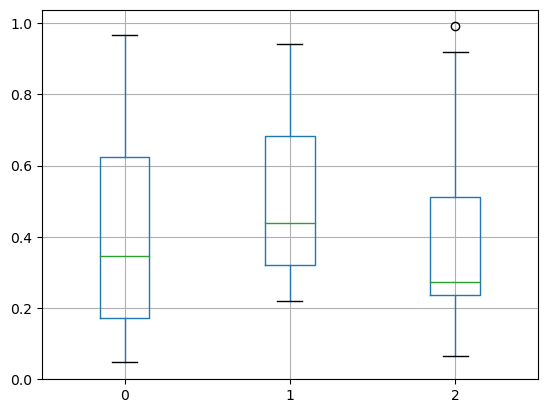

In [68]:
## Checking for outliers

pd_inp.boxplot() # OUTLIER DEDECTED ON THE 3RD FEATURE OF INPUTS
plt.show()

<Axes: >

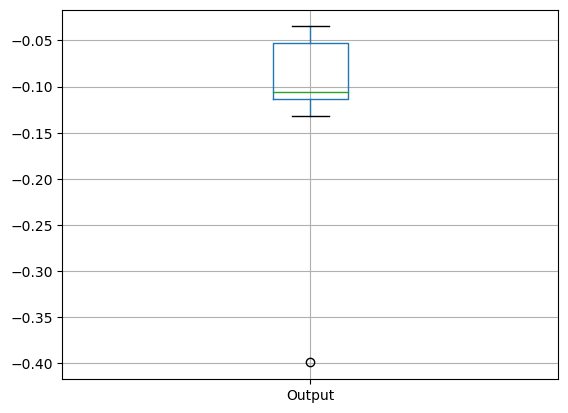

In [69]:
pd_out.boxplot() # OUTLIER DEDECTED

## Distribution 

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

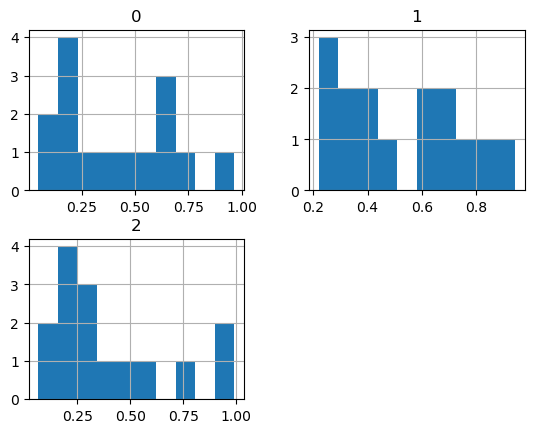

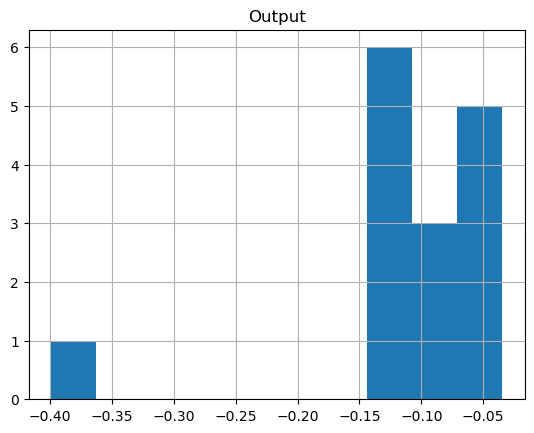

In [70]:
pd_inp.hist(), pd_out.hist()

In [71]:
# I doubt that the distribution is impacted from the outliers. CONSIDERING TO TRANFORM/OUTLIERS 

In [72]:
skew(f1_inp),skew(f1_out)


np.var(f1_inp),np.var(f1_out)

(0.06831771849145019, 0.007091996715577314)

# Input/Output Relationship Analysis 

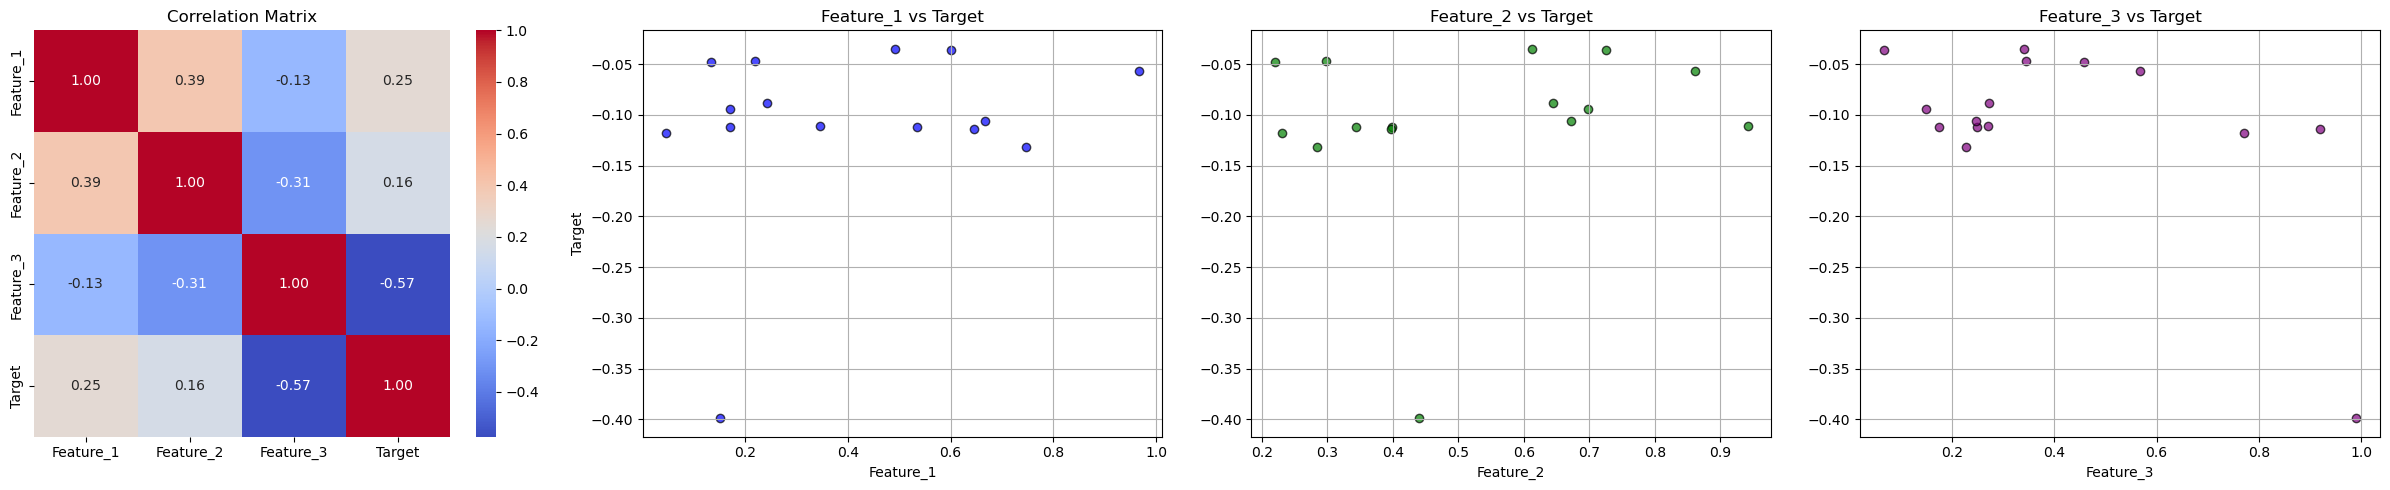

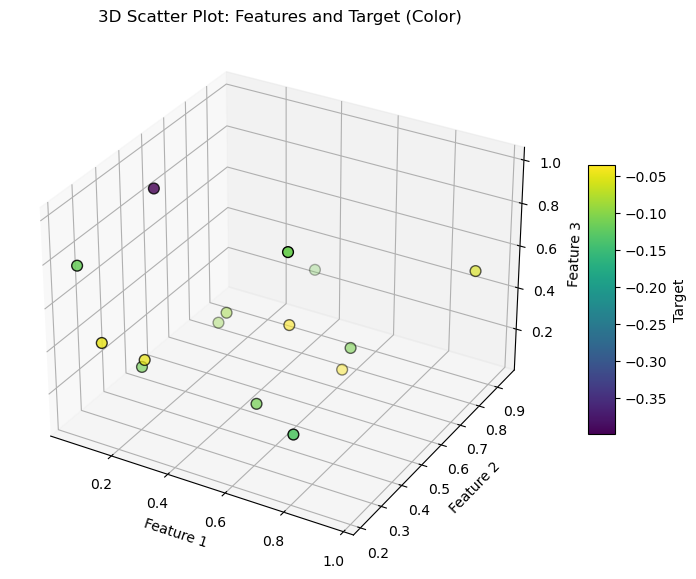

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Ensure f1_out is 1D
f1_out = f1_out.ravel()

# Create a figure for the inline plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# **1. Correlation Matrix**
# Convert f1_inp and f1_out to a single NumPy array for correlation
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Plot correlation heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix")

# **2. Scatter Plot: Feature 1 vs Target**
axes[1].scatter(f1_inp[:, 0], f1_out, color="blue", alpha=0.7, edgecolor="k")
axes[1].set_xlabel("Feature_1")
axes[1].set_ylabel("Target")
axes[1].set_title("Feature_1 vs Target")
axes[1].grid(True)

# **3. Scatter Plot: Feature 2 vs Target (if exists)**
if f1_inp.shape[1] > 1:
    axes[2].scatter(f1_inp[:, 1], f1_out, color="green", alpha=0.7, edgecolor="k")
    axes[2].set_xlabel("Feature_2")
    axes[2].set_title("Feature_2 vs Target")
    axes[2].grid(True)
else:
    axes[2].axis("off")
    axes[2].set_title("Feature_2 vs Target (Not Available)")

# **4. Scatter Plot: Feature 3 vs Target (if exists)**
if f1_inp.shape[1] > 2:
    axes[3].scatter(f1_inp[:, 2], f1_out, color="purple", alpha=0.7, edgecolor="k")
    axes[3].set_xlabel("Feature_3")
    axes[3].set_title("Feature_3 vs Target")
    axes[3].grid(True)
else:
    axes[3].axis("off")
    axes[3].set_title("Feature_3 vs Target (Not Available)")

plt.tight_layout()
plt.show()

# **3D Scatter Plot for Three Features**
# Only proceed if there are at least 3 features
if f1_inp.shape[1] >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # import 3D plotting toolkit

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Use the first three features for the 3D scatter plot
    x, y, z = f1_inp[:, 0], f1_inp[:, 1], f1_inp[:, 2]
    sc = ax.scatter(x, y, z, c=f1_out, cmap="viridis", edgecolor="k", s=60)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    plt.title("3D Scatter Plot: Features and Target (Color)")

    cb = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cb.set_label("Target")
    plt.show()
else:
    print("3D scatter plot requires at least 3 features in the input data.")


### Conclusion about input/ouput relationship
- Feature 2 has a very small correlation with the target variable, considering to remove it 



# DROPING FEATURE 2 

In [23]:
f1_inp = np.delete(f1_inp, 1, axis=1) 
f1_inp

array([[0.17152521, 0.2487372 ],
       [0.24211446, 0.27243281],
       [0.53490572, 0.17338873],
       [0.49258141, 0.34017639],
       [0.13462167, 0.45820622],
       [0.34552327, 0.26936348],
       [0.15183663, 0.99088187],
       [0.64550284, 0.91977134],
       [0.74691195, 0.22629985],
       [0.17047699, 0.14916943],
       [0.22054934, 0.34355534],
       [0.66601366, 0.2462953 ],
       [0.04680895, 0.77061759],
       [0.60009728, 0.06608864],
       [0.96599485, 0.56682913]])

In [74]:
f1_inp

array([[0.17152521, 0.2487372 ],
       [0.24211446, 0.27243281],
       [0.53490572, 0.17338873],
       [0.49258141, 0.34017639],
       [0.13462167, 0.45820622],
       [0.34552327, 0.26936348],
       [0.15183663, 0.99088187],
       [0.64550284, 0.91977134],
       [0.74691195, 0.22629985],
       [0.17047699, 0.14916943],
       [0.22054934, 0.34355534],
       [0.66601366, 0.2462953 ],
       [0.04680895, 0.77061759],
       [0.60009728, 0.06608864],
       [0.96599485, 0.56682913]])

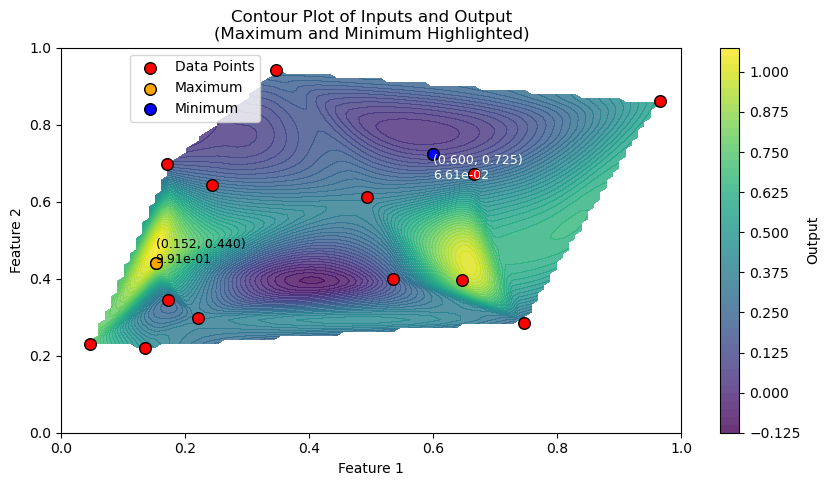

Max: 9.91e-01 at (0.1518, 0.4400)
Min: 6.61e-02 at (0.6001, 0.7251)


In [24]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
plt.legend()
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))

plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")

- From above we could see that Feature 1 was more correlated with output variable, so we might exepect that to grow on the result of acquistion function

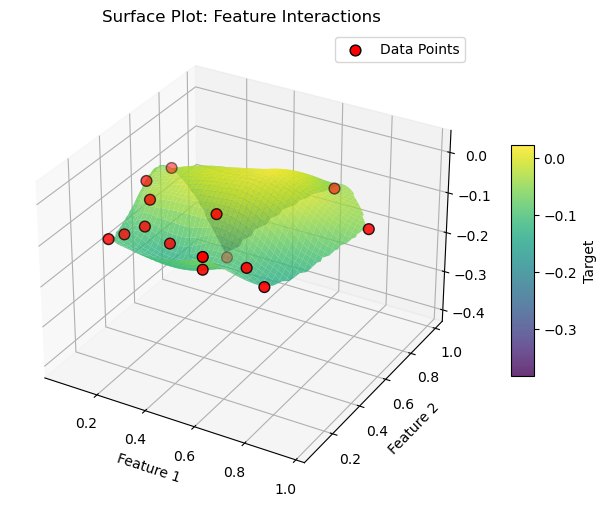

In [22]:
x, y = f1_inp[:, 0], f1_inp[:, 1]
z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
- Test after you have built the surrogate model, if there are future that just add noise and affect predictions 

In [ ]:
# Analysing skewnes and variance 




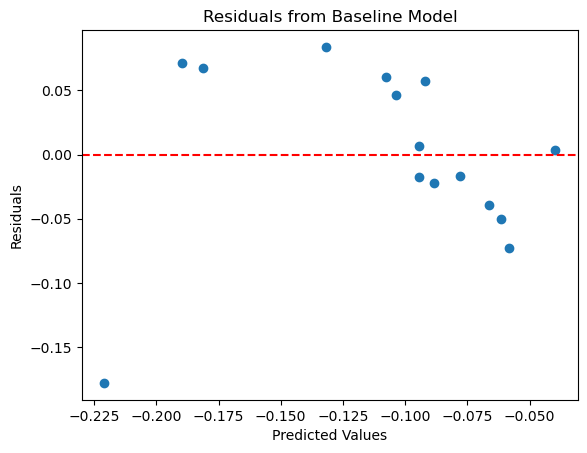

Residual Variance: 0.005
Residual Mean: 0.000


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [27]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 0.003
Residual Variance (Noise): 0.005
Residual Skewnes : -0.974
Signal-to-Noise Ratio (SNR): 0.562



### Conclusion
- Weak signal compared to noise
- Residuals show negative skew
- Low SNR calls for model/data improvements

# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [31]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension


amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]

(0.08716976488179329,
 array([0.27503944, 0.28414173]),
 [array([-0.04510964, -0.02639068]), array([1.05791344, 1.08336119])])

- Start with the above Amplitude but let the optimizer refine it during training

In [29]:
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
length_scale_init

array([0.27503944, 0.28414173])

- Start with the above Lenfthscale but let the optimizer refine it during training

In [83]:
# Bounds will always be the bounds of the input variable, IMPORTANT TO CHECK FOR OUTLIERS

In [30]:
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension
extended_min_bounds, extended_max_bounds

(array([-0.04510964, -0.02639068]), array([1.05791344, 1.08336119]))

Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds

In [86]:
# As per the above step there was some unexplained noise so the bounds have been extended 10% 

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



In [10]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Assuming f1_out is a NumPy array or a pandas Series
f1_out_transformed = PowerTransformer(method='yeo-johnson').fit_transform(f1_out.reshape(-1, 1))

# The transformed data is now stored in f1_out_transformed
f1_out, f1_out_transformed



(array([-0.1121222 , -0.08796286, -0.11141465, -0.03483531, -0.04800758,
        -0.11062091, -0.39892551, -0.11386851, -0.13146061, -0.09418956,
        -0.04694741, -0.10596504, -0.11804826, -0.03637783, -0.05675837]),
 array([[-0.49100107],
        [-0.01165121],
        [-0.47855102],
        [ 1.57226657],
        [ 1.09388181],
        [-0.46447942],
        [-2.2350453 ],
        [-0.52135676],
        [-0.79960263],
        [-0.14657628],
        [ 1.12995874],
        [-0.37965614],
        [-0.59190897],
        [ 1.51271561],
        [ 0.81100605]]))

In [ ]:
f1_out_transformed

# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)

f1_inp_normalized

array([[0.13568121, 0.17187734, 0.19750205],
       [0.21247662, 0.58792901, 0.22312465],
       [0.53100985, 0.24753692, 0.11602603],
       [0.48496443, 0.54290661, 0.29637733],
       [0.09553314, 0.        , 0.42400568],
       [0.32497705, 1.        , 0.21980572],
       [0.11426163, 0.30504628, 1.        ],
       [0.65133058, 0.24565461, 0.92310656],
       [0.7616555 , 0.08909797, 0.17324004],
       [0.13454084, 0.6613349 , 0.08983715],
       [0.18901551, 0.10798919, 0.30003107],
       [0.6736447 , 0.62661661, 0.19486157],
       [0.        , 0.01586128, 0.76182322],
       [0.60193301, 0.70028924, 0.        ],
       [1.        , 0.8887782 , 0.54146211]])

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel

# Kumaraswamy warping function
def kumaraswamy_warp(x, a, b):
    x = np.clip(x, 1e-10, 1 - 1e-10)  # Avoid numerical issues
    return 1 - (1 - x**a)**b

# Normalize input data
def normalize_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)



In [7]:
from scipy.stats import skew
from tqdm import tqdm
import numpy as np

# Define ranges for parameters a and b
a_values = np.linspace(0.01, 2.0, 100)  # 1000 values between 0.1 and 2.0
b_values = np.linspace(0.01, 2.0, 100)  # 1000 values between 0.1 and 2.0

# Initialize variables to store the best results
best_a, best_b = None, None
best_variance = float("inf")
best_skewness = float("inf")
best_score = float("inf")

# Total iterations for tqdm
total_iterations = len(a_values) * len(b_values)

# Loop through all combinations of a and b with a progress bar
with tqdm(total=total_iterations, desc="Searching for Best Kumaraswamy Parameters") as pbar:
    for a in a_values:
        for b in b_values:
            # Apply Kumaraswamy warping (replace this with your implementation)
            f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=a, b=b)
            
            # Calculate variance and skewness
            variance = np.var(f1_inp_warped)
            skewness = np.mean(np.abs(skew(f1_inp_warped, axis=0)))  # Mean absolute skewness across features

            # Combine variance and skewness into a single score
            score = variance + skewness  # Adjust weight if needed

            # Update the best parameters if the score is improved
            if score < best_score:
                best_a, best_b = a, b
                best_variance = variance
                best_skewness = skewness
                best_score = score

            # Update progress bar
            pbar.update(1)

# Print the best parameters and corresponding metrics
print(f"Best Parameters: a={best_a:.10f}, b={best_b:.10f}")
print(f"Reduced Variance: {best_variance:.6f}")
print(f"Reduced Skewness: {best_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                            | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_12708\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.05it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.330648
b = 0.576336
Combined Score (Variance + Skewness) = 0.219161
Final Variance: 0.059176
Final Skewness: 0.159985


In [58]:
# Not happy with the above result, I will try another strategy to get the best parametrs for the KUMARASUAMMY 

#!pip install deap


  Obtaining dependency information for deap from https://files.pythonhosted.org/packages/e9/bd/654aa594a0ac14063fe591c3339062441eeda3815017e2f66d0b762cccb0/deap-1.4.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/109.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/109.8 kB ? eta -:--:--
   ------- -------------------------------- 20.5/109.8 kB ? eta -:--:--
   -------------- ------------------------ 41.0/109.8 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 109.8/109.8 kB 1.1 MB/s eta 0:00:00


In [59]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                            | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_17480\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.663489
b = 1.441400
Combined Score (Variance + Skewness) = 0.238710
Final Variance: 0.077096
Final Skewness: 0.161614


In [15]:

# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.663489, b=1.441400)
f1_inp, f1_inp_warped


np.var(f1_inp),skew(f1_inp), np.var(f1_inp_warped),skew(f1_inp_warped)


(0.07709586487593663,
 array([-3.23229376e-01, -1.02827694e-06]),
 0.08411555532748485,
 array([-3.23229376e-01, -4.19351770e-01, -1.02827694e-06]))

In [ ]:
# SKEWNES IMPROVED/ POSITIVE RESULT

In [16]:
f1_inp = f1_inp_warped
f1_out  = f1_out_transformed


# ***************************** Gaussian Process****************************


In [ ]:
amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]
(0.08716976488179329,
 array([0.27503944, 0.28414173]),
 [array([-0.04510964, -0.02639068]), array([1.05791344, 1.08336119])])

# Testing Diffrent Kernels 

In [80]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from tqdm import tqdm  # For the progress bar

# Replace with your actual dataset
X = f1_inp  # Input features
y = f1_out  # Output/target

# Provided initial parameters and bounds for an isotropic kernel
amplitude_init = 0.08716976488179329
length_scale_init = 0.27503944  # Use a single scalar for isotropic kernel

# Ensure minimum bound is positive and use scalar bounds
min_bound = max(-0.04510964, 1e-6)
max_bound = 1.05791344  # Use first element as representative for scalar bound
bounds_scalar = (min_bound, max_bound)

# Define a small range around the initial length scale for search
length_scales = np.linspace(0.9 * length_scale_init, 1.1 * length_scale_init, 10)

# Kernel templates using lambdas for different kernel configurations
kernel_templates = {
    "Matern_nu_1.5": lambda ls, b: Matern(length_scale=ls, nu=1.5, length_scale_bounds=b),
    "Matern_nu_2.5": lambda ls, b: Matern(length_scale=ls, nu=2.5, length_scale_bounds=b),
    "RationalQuadratic": lambda ls, b: RationalQuadratic(
                                    length_scale=ls,
                                    alpha=1.0,
                                    length_scale_bounds=b,
                                    alpha_bounds=(1e-2, 100))
}

# Storage for results
results = []

# Setup progress bar total iterations
total_iterations = len(kernel_templates) * len(length_scales)
progress_bar = tqdm(total=total_iterations, desc="Tuning Kernels")

for kernel_name, kernel_func in kernel_templates.items():
    for ls in length_scales:
        # Create kernel with constant amplitude, base kernel, and white noise
        base_kernel = kernel_func(ls, bounds_scalar)
        kernel = C(amplitude_init, constant_value_bounds=(amplitude_init*0.6, amplitude_init*1.1)) * base_kernel \
             + WhiteKernel(noise_level=1e-12, noise_level_bounds=(1e-12, 1e-4))

        # Train Gaussian Process with the current kernel setup
        try:
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
            gp.fit(X, y)

            # Calculate Log Marginal Likelihood (LML)
            lml = gp.log_marginal_likelihood()

            # Store results
            results.append({
                "Kernel": kernel_name,
                "Length Scale": ls,
                "Bounds": bounds_scalar,
                "Kernel Parameters": str(kernel),
                "LML": lml,
            })
        except Exception as e:
            # Log any errors encountered
            results.append({
                "Kernel": kernel_name,
                "Length Scale": ls,
                "Bounds": bounds_scalar,
                "Kernel Parameters": str(kernel),
                "LML": None,
                "Error": str(e),
            })
        progress_bar.update(1)

progress_bar.close()

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort results by LML (Log Marginal Likelihood) for better kernels
results_df = results_df.sort_values(by="LML", ascending=False, na_position='last')

results_df.head()  # Display top results


Tuning Kernels:   0%|                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.05230185892907597. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-12. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Tuning Kernels:   3%|██▏                                                                | 1/30 [00:00<00:03,  7.30it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dim

Tuning Kernels:  37%|████████████████████████▏                                         | 11/30 [00:01<00:02,  6.35it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.05230185892907597. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.0001. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Tuning Kernels:  40%|██████████████████████████▍                                       | 12/30 [00:01<00:03,  5.89it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for di

Tuning Kernels:  73%|████████████████████████████████████████████████▍                 | 22/30 [00:04<00:02,  3.23it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.05230185892907597. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-12. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Tuning Kernels:  77%|██████████████████████████████████████████████████▌               | 23/30 [00:04<00:02,  2.91it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dim

,Kernel,Length Scale,Bounds,Kernel Parameters,LML
25,RationalQuadratic,0.278095,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",16.946507
20,RationalQuadratic,0.247535,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",16.946507
27,RationalQuadratic,0.290319,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",16.946507
23,RationalQuadratic,0.265871,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",16.946507
24,RationalQuadratic,0.271983,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",16.946507


- First best test result 
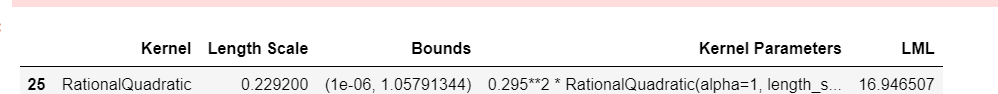

- Result after transformation of input and output 
#### I will not tranform - I will address outliers to see potential result
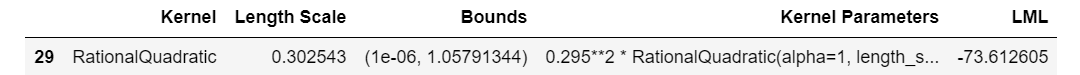

In [63]:
results_df.head(1)


# Rational QUADRATIC GIVING ME SLIGHLY A BETTER VALUE. 
## I WILL NOW TRANFORM INPUT OUPUT. AND TEST AGAIN 

,Kernel,Length Scale,Bounds,Kernel Parameters,LML
29,RationalQuadratic,0.302543,"(1e-06, 1.05791344)","0.295**2 * RationalQuadratic(alpha=1, length_s...",-73.612605



### Rational Quadritic Kernel is having the best score so far
- The good news is with this kernel we do not need to standarise the data as per the below instruction 
- Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000),

In [89]:
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# Define a composite kernel with initial parameters and bounds
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(
    length_scale=0.237,
    alpha=1.0,
    length_scale_bounds=(0.05, 1.1),
    alpha_bounds=(1e-2, 1)
) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y)
print("Optimized Kernel:", gp.kernel_)
print("LML:", gp.log_marginal_likelihood())


Optimized Kernel: 0.168**2 * RationalQuadratic(alpha=0.383, length_scale=0.256) + WhiteKernel(noise_level=5.52e-11)
LML: 17.108517317508948


# - Final Kernel 

In [78]:
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel as C, RBF

# Define a composite kernel with initial parameters and bounds
kernel = (
    C(1.0, (1e-14, 1e3)) *  # ConstantKernel: Scale parameter with specified bounds
    (RBF(length_scale=1, length_scale_bounds=(3.43e-7, 1.0)) +  # Smooth trends
     ExpSineSquared(length_scale=1, periodicity=2,  # Periodic component
                    length_scale_bounds=(3.43e-7, 1.0),
                    periodicity_bounds=(1e-2, 1e1)))
    + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-11, 1e-1))  # Noise
)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(f1_inp, f1_out)
print("Optimized Kernel:", gp.kernel_)
print("LML:", gp.log_marginal_likelihood())


Optimized Kernel: 0.113**2 * RBF(length_scale=0.171) + ExpSineSquared(length_scale=0.88, periodicity=10) + WhiteKernel(noise_level=3.81e-05)
LML: 17.437752256832383


C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__periodicity is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [61]:
import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
#pip install pymoo

# ----------------------------------------------------------------
# 1. Stochastic Mean
# ----------------------------------------------------------------

#### I will add a sigma in order to explore further 
def stochastic_mean(mu, noise_var, xi=1.0): #Param2
    """
    HEBO's stochastic mean: m_HEBO(x) = m(x) + xi * noise_var
    mu        : GP predictive mean (array)
    noise_var : GP's noise variance (scalar or array)
    xi        : Weight for noise exploration
    """
    return mu + xi * (noise_var ) ## To be ammended so xi can be added 
                               ## depending on the weight/trade we want the ACQ function to have

# ----------------------------------------------------------------
# 2. Single-Point Acquisitions: alpha_q-EI, alpha_q-PI, alpha_q-UCB
#    (Here q=1, so no batching).
# ----------------------------------------------------------------
def alpha_ei(mu, sigma, best_so_far):
    """
    q-EI => EI; we can do a log transform if needed.
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def alpha_pi(mu, sigma, best_so_far):
    """
    q-PI => PI
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    pi = norm.cdf(Z)
    return pi

def alpha_ucb(mu, sigma, beta=2.5): #Param1
    """
    q-UCB => UCB
    """
    return mu + beta * sigma

# Optional: log transform for alpha_q-EI
def log_alpha_ei(mu, sigma, best_so_far):
    """
    Approx. log of EI to handle large negative Z.
    Use a piecewise approximation for Z < -6, else exact log(EI).
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    # EI
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    # Approx for extreme negative Z
    if Z < -6:
        # Based on the limit in the paper
        return np.log(sigma) - 0.5 * Z**2 - np.log(Z**2 - 1) - 0.5 * np.log(2 * np.pi)
    else:
        return np.log(np.maximum(ei, 1e-16))

# ----------------------------------------------------------------
# 3. Multi-Objective MACE Setup with pymoo
#    We want to minimize [-alphaEI, -alphaPI, alphaUCB].
#    This gives a Pareto front across multiple acquisitions.
# ----------------------------------------------------------------
class MACEProblem(Problem):
    def __init__(self, gp, bounds, best_so_far, beta=2.5, xi=1.0):
        super().__init__(n_var=len(bounds), n_obj=3, xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
        self.gp = gp
        self.best_so_far = best_so_far
        self.beta = beta
        self.xi = xi

    def _evaluate(self, X, out, *args, **kwargs):
        mu, sigma = self.gp.predict(X, return_std=True)
        noise_var = getattr(self.gp.kernel_, 'noise_level', 1e-9)  # or from WhiteKernel
        # Stochastic mean
        mu_hebo = stochastic_mean(mu, noise_var, self.xi)
        # Evaluate acquisitions
        val_ei = alpha_ei(mu_hebo, sigma, self.best_so_far)   # -(EI)
        val_pi = alpha_pi(mu_hebo, sigma, self.best_so_far)   # -(PI)
        val_ucb = alpha_ucb(mu_hebo, sigma, self.beta)        # UCB
        # Convert to array [obj1, obj2, obj3]
        # Minimizing => negative for EI, PI
        out["F"] = np.column_stack([-val_ei, -val_pi, val_ucb])

def multi_objective_acquisition_mace(gp, bounds, best_so_far, beta=2.5, xi=1.0, pop_size=50, n_gen=200): #Param6 (if high dimesnion we can go up to 200 n_gen)
    """
    Solve the MACE problem with NSGA-II using pymoo.
    Returns the Pareto set of points.
    """
    problem = MACEProblem(gp, bounds, best_so_far, beta=beta, xi=xi)
    algorithm = NSGA2(pop_size=pop_size)
    res = minimize(problem, algorithm, ("n_gen", n_gen), verbose=False)
    return res.X, res.F  # Pareto solutions and their objective values


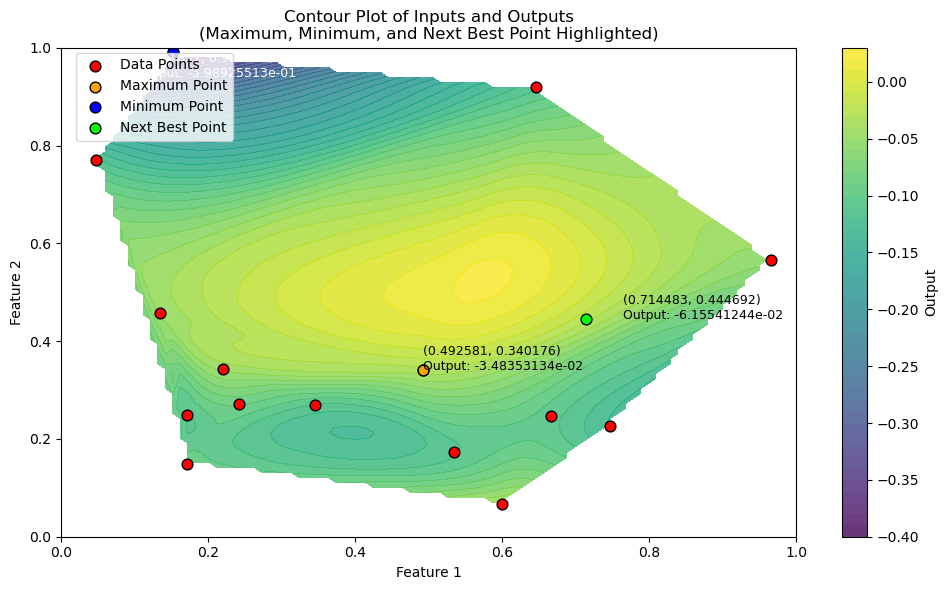

Maximum Value: -3.48353134e-02 at (x1=0.4926, x2=0.3402)
Minimum Value: -3.98925513e-01 at (x1=0.1518, x2=0.9909)
Next Best Point (WPI): -6.15541244e-02 at (x1=0.714483, x2=0.444692)


In [80]:
from scipy.optimize import minimize
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic, WhiteKernel
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

def weighted_probability_of_improvement(X, gp, current_best, w=1.0):
    mu, sigma = gp.predict(X, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - current_best) / sigma
    return w * norm.cdf(Z)

def optimize_acquisition_wpi(acquisition_func, gp, bounds, current_best,
                             w=1.0, n_restarts=20, epsilon=0.1):
    """
    - n_restarts: Number of random restarts for local optimization.
    - epsilon: Probability of picking a random point (epsilon-greedy).
    """
    # 1) With probability epsilon, choose a purely random point (exploration).
    if np.random.rand() < epsilon:
        return np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    
    # 2) Otherwise, do a multi-restart local search
    best_x = None
    best_val = float("inf")
    dim = len(bounds)

    for _ in range(n_restarts):
        x0 = np.random.uniform([b[0] for b in bounds],
                               [b[1] for b in bounds],
                               size=(dim,))
        
        res = minimize(
            fun=lambda X: -acquisition_func(X.reshape(1, -1), gp, current_best, w=w),
            x0=x0,
            bounds=bounds,
            method="L-BFGS-B"
        )
        
        # Track best result
        if res.fun < best_val and res.success:
            best_val = res.fun
            best_x = res.x

    # If for some reason all attempts fail, fallback to random
    if best_x is None:
        best_x = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    
    return best_x



## to avoid getting stuck into local minimas 
# when exploration is important
# higher dimension

##-------------------

# GP model
def fit_gp_model(f1_inp, f1_out):
    kernel = (
        C(1.0, (1e-14, 1e3)) *
        RationalQuadratic(length_scale=1, alpha=1,
                          length_scale_bounds=(3.43e-7, 1.0),
                          alpha_bounds=(1e-6, 1))
        + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-11, 1e-1)) #Param3
    )
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=42)
    gp.fit(f1_inp, f1_out)
    return gp

# Main Workflow
gp = fit_gp_model(f1_inp, f1_out)
bounds = [(0, 1) for _ in range(f1_inp.shape[1])]
current_best = np.max(f1_out)


w = 1.3 #Param4
next_point = optimize_acquisition_wpi(
    weighted_probability_of_improvement,
    gp,
    bounds,
    current_best,
    w=1.3,
    n_restarts=30,     # more restarts
    epsilon=0.1        # small chance for random pick
)

next_z = gp.predict(next_point.reshape(1, -1))[0]

# -----------------------------------------------------Visualization---------------------------------------------------------------------
x = f1_inp[:, 0]
y = f1_inp[:, 1]
z = f1_out.ravel()
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

max_idx = np.argmax(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_idx = np.argmin(z)
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
s = 60

plt.scatter(x, y, color='red', label="Data Points", edgecolor='black', s=s)
plt.scatter(max_x, max_y, color='orange', edgecolor='black', s=s, label="Maximum Point")
plt.text(max_x, max_y, f"({max_x:.6f}, {max_y:.6f})\nOutput: {max_z:.8e}", color='black', fontsize=9)
plt.scatter(min_x, min_y, color='blue', edgecolor='black', s=s, label="Minimum Point")
plt.text(min_x - 0.05, min_y - 0.05, f"({min_x:.6f}, {min_y:.6f})\nOutput: {min_z:.8e}", color='white', fontsize=9)
plt.scatter(next_point[0], next_point[1], color='lime', edgecolor='black', s=s, label="Next Best Point")
plt.text(
    next_point[0] + 0.05, next_point[1],
    f"({next_point[0]:.6f}, {next_point[1]:.6f})\nOutput: {next_z:.8e}",
    color='black',
    fontsize=9
)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Outputs\n(Maximum, Minimum, and Next Best Point Highlighted)")
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.9))
plt.tight_layout()
plt.show()

print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.4f})")
print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.4f})")
print(f"Next Best Point (WPI): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")


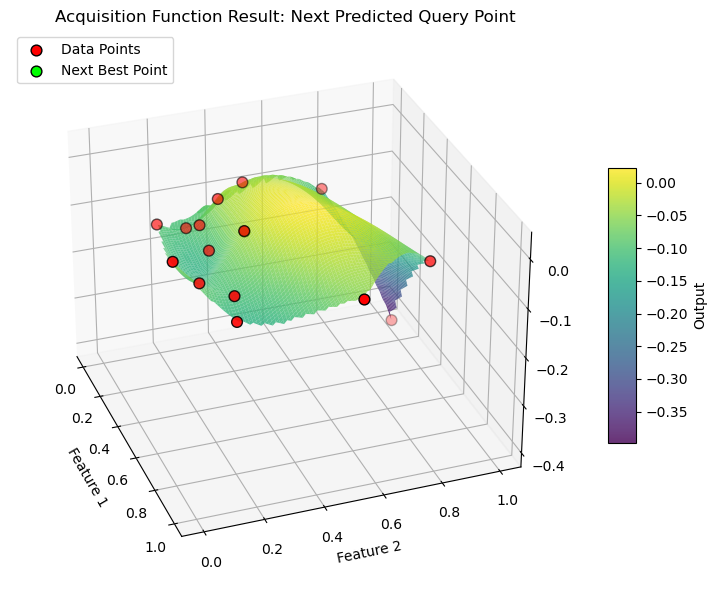

Next Best Point (WPI): at (x1=0.492781, x2=0.340774)


In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface with fine resolution and smoother appearance
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none', rcount=100, ccount=100
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter points
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
#ax.scatter(max_x, max_y, max_z, color='orange', edgecolor='black', s=60, label="Maximum Point")
#ax.scatter(min_x, min_y, min_z, color='blue', edgecolor='black', s=60, label="Minimum Point")
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
# ax.set_zlabel("Output")
ax.set_title("Acquisition Function Result: Next Predicted Query Point", loc="center")



# Custom viewing angle and legend
ax.view_init(elev=30, azim=-20)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f"Next Best Point (WPI): at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")



In [202]:
# Changed to the below for mor explotation 

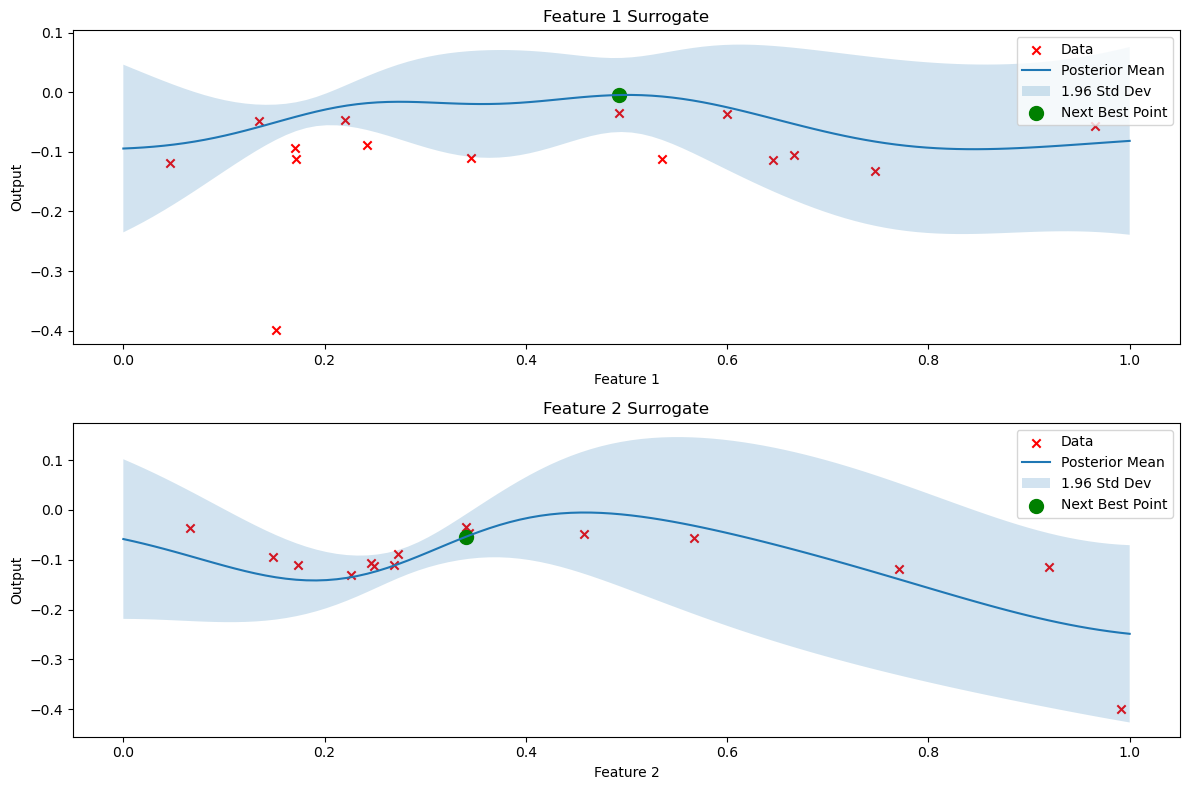

Next best point (full 4D): [0.49274203 0.34065609]
Predicted mean at next best point: -0.034483970793046215
Predicted std at next best point: 0.0002198277423979493


In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Train GP (already done):
# gp = fit_gp_model(f1_inp, f1_out)

# 2) Calculate the mean for each feature to hold others constant
means_other_features = np.mean(f1_inp, axis=0)

# 3) Choose how many points you want to plot in the grid
n_points = 100
beta = 1.96  # for ~95% CI

# 4) Predict the overall mean/std at the next best point (for reference)
next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes = axes.ravel()  # Flatten for easy iteration over 4 features

for i in range(f1_inp.shape[1]):
    # Create a grid along the i-th feature
    grid = np.linspace(0, 1, n_points)
    
    # For each point in the grid, set all other features to their means
    X_plot = np.tile(means_other_features, (n_points, 1))
    X_plot[:, i] = grid
    
    # Predict mean and std from the GP
    mean_pred, std_pred = gp.predict(X_plot, return_std=True)

    # Plot training data (feature i vs output)
    axes[i].scatter(f1_inp[:, i], f1_out, color='r', marker='x', label='Data')
    
    # Plot posterior mean
    axes[i].plot(grid, mean_pred, label='Posterior Mean')
    
    # Confidence interval
    axes[i].fill_between(grid,
                         mean_pred - beta*std_pred,
                         mean_pred + beta*std_pred,
                         alpha=0.2,
                         label=f'{beta} Std Dev')
    
    # Plot the next best point (for feature i)
    # We'll compute its partial dependence by fixing other features at means:
    X_next = means_other_features.copy()
    X_next[i] = next_point[i]
    y_next_dim = gp.predict(X_next.reshape(1, -1))[0]

    axes[i].scatter(next_point[i], y_next_dim, marker='o', color='green',
                    s=100, label='Next Best Point')
    
    axes[i].set_title(f'Feature {i+1} Surrogate')
    axes[i].set_xlabel(f'Feature {i+1}')
    axes[i].set_ylabel('Output')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("Next best point (full 4D):", next_point)
print("Predicted mean at next best point:", next_mean[0])
print("Predicted std at next best point:", next_std[0])
